<a href="https://colab.research.google.com/github/olehpetrovasyliev/daest2/blob/main/Furniture_Store_Sales_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Furniture Store Sales Analysis**

Welcome to this comprehensive analysis of an e-commerce platform's performance over a three-month period. In this study, we delve into user behavior and sales trends metrics across various dimensions including geography, device usage, and product categories. By leveraging session and transaction data, we aim to uncover actionable insights that can drive strategic decisions and optimize marketing efforts. Whether you're looking to understand regional preferences, identify high-performing categories, or evaluate channel effectiveness, this analysis provides a detailed overview to guide your next steps.



## 0. Service info

The following code hasn`t any analytical value, but is required for extracting and handling data.

It includes:
- Imports of Libs
- Auth Setttings
- SQL Query

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from scipy import stats
import seaborn as sns
import statsmodels.api as sm
import plotly.graph_objects as go


from google.colab import auth
from google.cloud import bigquery
from scipy.stats import normaltest

In [ ]:
auth.authenticate_user()

In [ ]:
client = bigquery.Client(project="data-analytics-mate")

In [ ]:
query = """
SELECT
  date,
  ga_session_id,
  continent,
  country,
  device,
  browser,
  mobile_model_name,
  operating_system,
  language,
  medium,
  channel,
  account_id,
  is_verified,
  is_unsubscribed,
  category,
  item_id,
  p.name,
  price,
  short_description
FROM
  `data-analytics-mate.DA.session` s
JOIN
  `data-analytics-mate.DA.session_params` sp
USING(ga_session_id)
LEFT JOIN
 `data-analytics-mate.DA.account_session` acs
USING(ga_session_id)
LEFT JOIN `data-analytics-mate.DA.account`  a
ON  acs.account_id = a.id
LEFT JOIN `data-analytics-mate.DA.order`  o
USING(ga_session_id)
LEFT JOIN `data-analytics-mate.DA.product`  p
USING(item_id)
ORDER BY date

"""


## 1. DataFrame Creation And Processing

### DataFrame Creation

In this block, we will create a dataframe from the dataset we`re working with, analyze data and its quality, and process it for future work
It includes:
- DataFrame Creation
- Explorational Data Analysis
- DataFrame Processing

In [ ]:
query_job = client.query(query)
results = query_job.result()
sessions = results.to_dataframe()

sessions.head()

,date,ga_session_id,continent,country,device,browser,mobile_model_name,operating_system,language,medium,channel,account_id,is_verified,is_unsubscribed,category,item_id,name,price,short_description
0,2020-11-01,7052560603,(not set),(not set),mobile,Chrome,<Other>,Web,None,<Other>,Paid Search,<NA>,<NA>,<NA>,None,<NA>,None,NaN,None
1,2020-11-01,6164084975,(not set),(not set),mobile,Safari,iPhone,Web,None,(data deleted),Undefined,<NA>,<NA>,<NA>,None,<NA>,None,NaN,None
2,2020-11-01,542050872,Asia,India,desktop,Edge,Edge,Web,None,referral,Social Search,<NA>,<NA>,<NA>,None,<NA>,None,NaN,None
3,2020-11-01,1794022887,Asia,India,desktop,Chrome,Chrome,Web,en-us,referral,Paid Search,<NA>,<NA>,<NA>,None,<NA>,None,NaN,None
4,2020-11-01,1546135823,Asia,Saudi Arabia,desktop,Safari,Safari,Web,en-us,referral,Social Search,654428,1,0,None,<NA>,None,NaN,None


###DataFrame Processing

In [ ]:
sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349545 entries, 0 to 349544
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   date               349545 non-null  dbdate 
 1   ga_session_id      349545 non-null  Int64  
 2   continent          349545 non-null  object 
 3   country            349545 non-null  object 
 4   device             349545 non-null  object 
 5   browser            349545 non-null  object 
 6   mobile_model_name  349545 non-null  object 
 7   operating_system   349545 non-null  object 
 8   language           235279 non-null  object 
 9   medium             349545 non-null  object 
 10  channel            349545 non-null  object 
 11  account_id         27945 non-null   Int64  
 12  is_verified        27945 non-null   Int64  
 13  is_unsubscribed    27945 non-null   Int64  
 14  category           33538 non-null   object 
 15  item_id            33538 non-null   Int64  
 16  na

In [ ]:
print(sessions.isna().sum())

date                      0
ga_session_id             0
continent                 0
country                   0
device                    0
browser                   0
mobile_model_name         0
operating_system          0
language             114266
medium                    0
channel                   0
account_id           321600
is_verified          321600
is_unsubscribed      321600
category             316007
item_id              316007
name                 316007
price                316007
short_description    316007
dtype: int64


In [ ]:
print(sessions.isna().sum() / sessions.shape[0] * 100)

date                  0.000000
ga_session_id         0.000000
continent             0.000000
country               0.000000
device                0.000000
browser               0.000000
mobile_model_name     0.000000
operating_system      0.000000
language             32.689925
medium                0.000000
channel               0.000000
account_id           92.005321
is_verified          92.005321
is_unsubscribed      92.005321
category             90.405241
item_id              90.405241
name                 90.405241
price                90.405241
short_description    90.405241
dtype: float64


In [ ]:
duplicate_rows = sessions.duplicated()
duplicate_rows.sum()

np.int64(0)

As the `info()` function shows us, there are many missing values, mainly in sessions without transactions or user information. At this stage, we need to keep all this information to calculate conversions and overall session statistics.

Also, there are no duplicates in dataframe

However, some columns have incorrect data types

In [ ]:
sessions["ga_session_id"] = sessions["ga_session_id"].astype("string")
sessions["account_id"] = sessions["account_id"].astype("string")
sessions["is_verified"] = sessions["is_verified"].astype("string")
sessions["is_unsubscribed"] = sessions["is_unsubscribed"].astype("string")
sessions["item_id"] = sessions["item_id"].astype("string")

Also, we need to create new 2 dataframes which will include authorized users sessions and sessions with transactions only to optimize resource usage and discard data that will be unnecessary

As we could see from dataframe overview, the items names has same missing values count, which meand we have all required info about all the transactions and can just drop all the sessions without transactions to add in our new dataframe. same situation we have with user sessions

In [ ]:
transactions = sessions.dropna(subset=["price"])
transactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33538 entries, 6 to 336039
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               33538 non-null  dbdate 
 1   ga_session_id      33538 non-null  string 
 2   continent          33538 non-null  object 
 3   country            33538 non-null  object 
 4   device             33538 non-null  object 
 5   browser            33538 non-null  object 
 6   mobile_model_name  33538 non-null  object 
 7   operating_system   33538 non-null  object 
 8   language           22531 non-null  object 
 9   medium             33538 non-null  object 
 10  channel            33538 non-null  object 
 11  account_id         2781 non-null   string 
 12  is_verified        2781 non-null   string 
 13  is_unsubscribed    2781 non-null   string 
 14  category           33538 non-null  object 
 15  item_id            33538 non-null  string 
 16  name               33538 n

In [ ]:
user_sessions = sessions.dropna(subset=["account_id"])
user_sessions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27945 entries, 4 to 336074
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               27945 non-null  dbdate 
 1   ga_session_id      27945 non-null  string 
 2   continent          27945 non-null  object 
 3   country            27945 non-null  object 
 4   device             27945 non-null  object 
 5   browser            27945 non-null  object 
 6   mobile_model_name  27945 non-null  object 
 7   operating_system   27945 non-null  object 
 8   language           18744 non-null  object 
 9   medium             27945 non-null  object 
 10  channel            27945 non-null  object 
 11  account_id         27945 non-null  string 
 12  is_verified        27945 non-null  string 
 13  is_unsubscribed    27945 non-null  string 
 14  category           2781 non-null   object 
 15  item_id            2781 non-null   string 
 16  name               2781 no

## 2. Exploratory Data Analysis

Firstofall, we need to check out the dataset by info() function again just to keep the general picture close and check out if all the transformations went correctly


In [ ]:
sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349545 entries, 0 to 349544
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   date               349545 non-null  dbdate 
 1   ga_session_id      349545 non-null  string 
 2   continent          349545 non-null  object 
 3   country            349545 non-null  object 
 4   device             349545 non-null  object 
 5   browser            349545 non-null  object 
 6   mobile_model_name  349545 non-null  object 
 7   operating_system   349545 non-null  object 
 8   language           235279 non-null  object 
 9   medium             349545 non-null  object 
 10  channel            349545 non-null  object 
 11  account_id         27945 non-null   string 
 12  is_verified        27945 non-null   string 
 13  is_unsubscribed    27945 non-null   string 
 14  category           33538 non-null   object 
 15  item_id            33538 non-null   string 
 16  na

Now, after we assured that all data types are defined correctly, we can move on to EDA:


### Dataset Overview

**Total number of columns**: 18

**Number of numeric columns**: 1

**Numeric Columns**: `price`

**Number of categorical columns**: 16

**Columns**: `ga_session_id`, `continent`, `country`, `device`, `browser`, `mobile_model_name`,`operating system`, `language`, `medium`, `channel`, `account_id`, `is_verified`, `is_unsubscribed`, `category`, `name`, `price`, `short_descrption`  

**Number of datetime columns**: 1

**Columns**: `date`

### Fields Description


**date**: date when the session took place

**ga_session_id**: unique identifier of the session

**continent**: continent where the device was located during the session

**country**: country where the device was located during the session

**device**: type of device used for the session (mobile/desktop/tablet)

**browser**: name of the browser used in the session

**mobile_model_name**: name of the mobile device (for mobile sessions) or browser name (for other devices)

**operating_system**: operating system of the session device

**language**: browser language of the user in this session

**medium**: source of traffic that led to this session

**channel**: traffic channel that led to this session

**account_id**: identifier of the account (for authorized users)

**is_verified**: whether the user’s email is verified (0 = unverified, 1 = verified)

**is_unsubscribed**: whether the user is unsubscribed from the mailing list (0 = subscribed, 1 = unsubscribed)

**category**: category of the item sold

**item_id**:id of item sold

**name**: name of the item sold

**price**: price of the item sold

**short_description**: short description of the item sold

### Sessions

In [ ]:
registered_sessions = sessions[sessions['account_id'].notna()]
registered_purchases_count = registered_sessions['item_id'].notna().sum()
registered_purchases_count

np.int64(2781)

**Number of unique sessions**: 349 545

**Number of unique sessions with transactions**: 33 538

**Number of unique sessions from authorizes users**: 27 945

**Number of unique sessions from authorizes users with transactions**: 2 781

**Number of unique sessions from unauthorizes users with transactions**: 30 757

**Time period covered**: from 01/11/2020 to 31/01/2021

### Missing Values

**Are there missing values?**: Yes

**Columns with the most missing values**: `language`, `account_id`, `is_verified`, `is_unsubscribed`, `category`, `name`, `price`, `short_descrption`  

Possible reasons:
- Language not set or uses multilang profile
- Anonymous users
- Unauthorized users sessions
- Sessions without transactions

### Numeric values

considering that we only have one numeric column the default `describe()` method will satisfy all our needs at this stage

In [ ]:
transactions.describe() ## as we have price as the only numeric column, noo need to process huge sessions dataframe

,price
count,33538.000000
mean,953.298679
std,1317.001775
min,3.000000
25%,170.000000
50%,445.000000
75%,1195.000000
max,9585.000000


As we can notice, there is a very wide range, and a significant difference between the mean and the median. Mean is bigger, which already tells us that either distribution is right-skewed, or there are outliers in dataset.\
Also, the range is wery wide and median is much closer to q1(25%) than to q3(75%), which is another proof of right skewed distribution or outliers presence\
To investigate this further, let’s examine the distribution by plotting a histogram and providing a normaltest

Text(0.5, 1.0, 'Distribution of prices')

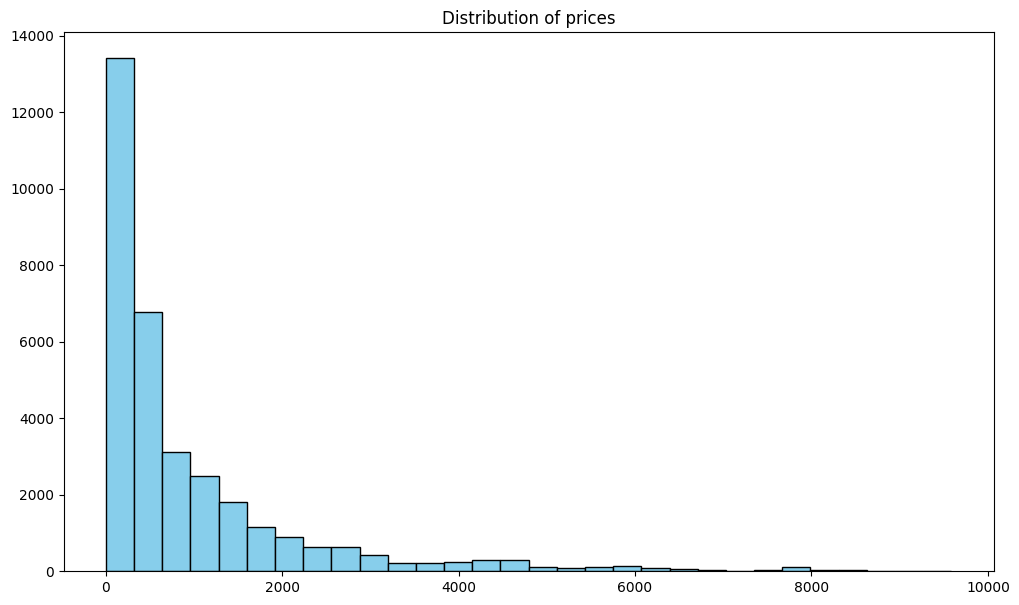

In [ ]:
plt.figure(figsize=(12, 7))
plt.hist(transactions["price"], bins=30, color="skyblue", edgecolor="black")
plt.title("Distribution of prices")


In [ ]:
_, p_value_normaltest_sessions = normaltest(transactions["price"])
print(f"Normaltest for sessions p-value: {p_value_normaltest_sessions}")

Normaltest for sessions p-value: 0.0


As we can see, the histogram and normaltest confirms my conclusios, p value is 0 and histogram is strongly right skewed. This information shows us, that majority of items are at small price, but there are also more expensive items, that we can find more rarely

### Conclusion

The dataset covers a three-month period and contains information on sessions, users, and purchases. Each user appears only once in the dataset: they either complete a purchase or not. Unregistered visitors (guests) are also treated as unique users and are assumed to have only a single session, with the same binary outcome of either purchasing or not. Importantly, the dataset does not allow for tracking repeated visits or purchases by the same individual across time. Consequently, the data reflects only unique one-time interactions within the observed three-month window.

## 3. Business Performance Analysis

In this section, we will explore sales and user behavior from multiple perspectives such as countries, categories, regions, etc. to identify key metrics

Finally, we gonna calculate conversions, both overall and clastered by metrics like geography, channels, timeline, etc., make an RTV segmentation, calculate retention rate and time-to-first-purchase

### 3.1. Business Performance Analysis by Continents

In [ ]:
continent_metrics = transactions.pivot_table(index="continent", values=["item_id", "price"], aggfunc={"item_id": "count", "price": "sum"}).reset_index().sort_values(by="price", ascending=False)

continent_metrics["avg_revenue"] = round(continent_metrics["price"] / continent_metrics["item_id"], 2)

continent_metrics

,continent,item_id,price,avg_revenue
2,Americas,18553,17665280.0,952.15
3,Asia,7950,7601298.3,956.14
4,Europe,6261,5934624.2,947.87
5,Oceania,364,365230.2,1003.38
1,Africa,339,331231.0,977.08
0,(not set),71,74067.4,1043.20


In [ ]:
continent_metrics_chart = px.bar(
    continent_metrics,
    x="continent",
    y="avg_revenue",
    title="Average Revenue by Continent",
    labels={"continent": "Continent", "avg_revenue": "Average Revenue"}
)
continent_metrics_chart.show()

The average revenue appears to be approximately the same, with no significant deviations observed. However, the Americas, Asia, and Europe stand out as the leading contributors to overall purchase volumes, positioning them as the primary drivers of revenue

### 3.2. Business Performance Analysis by Countries

In [ ]:
country_metrics = transactions.pivot_table(index="country", values=["item_id", "price"], aggfunc={"item_id": "count", "price": "sum"}).reset_index().sort_values(by="price", ascending=False)

country_metrics["avg_revenue"] = round(country_metrics["price"] / country_metrics["item_id"], 2)

country_metrics

,country,item_id,price,avg_revenue
104,United States,14673,13943553.9,950.29
43,India,3029,2809762.0,927.62
18,Canada,2560,2437921.0,952.31
103,United Kingdom,1029,938317.9,911.87
33,France,678,710692.8,1048.22
...,...,...,...,...
8,Bahamas,4,2411.0,602.75
38,Guatemala,7,2259.0,322.71
36,Ghana,6,1018.0,169.67
14,Bosnia & Herzegovina,5,939.0,187.80


In [ ]:
country_metrics_chart = px.bar(
    country_metrics,
    x="country",
    y="avg_revenue",
    title="Average Revenue by Сountry",
    labels={"country": "Сountry", "avg_revenue": "Average Revenue"}
)
country_metrics_chart.show()

At the country level, the variation in average revenue is much wider compared to continents. Nevertheless, the volume of purchases remains the key driver, with the United States, India, Canada, United Kingdom, and France emerging as the top contributors

### 3.3. Business Performance Analysis by Categories

In [ ]:
category_metrics = transactions.pivot_table(index="category", values=["item_id", "price"], aggfunc={"item_id": "count", "price": "sum"}).reset_index().sort_values(by="price", ascending=False)

category_metrics["avg_revenue"] = round(category_metrics["price"] / category_metrics["item_id"], 2)

category_metrics

,category,item_id,price,avg_revenue
12,Sofas & armchairs,4301,8388254.5,1950.30
5,Chairs,5952,6147748.8,1032.89
1,Beds,2926,4919725.0,1681.38
2,Bookcases & shelving units,7630,3640818.1,477.17
3,Cabinets & cupboards,2318,2336499.5,1007.98
9,Outdoor furniture,2229,2142222.2,961.07
13,Tables & desks,2941,1790307.5,608.74
6,Chests of drawers & drawer units,1452,906562.5,624.35
0,Bar furniture,1092,735503.0,673.54
7,Children's furniture,1702,467697.0,274.79


In [ ]:
category_metrics_chart = px.bar(
    category_metrics,
    x="category",
    y="avg_revenue",
    title="Average Revenue by Category",
    labels={"category": "Category", "avg_revenue": "Average Revenue"}
)
category_metrics_chart.show()

Across categories, the range of average revenue is significantly wider—large enough to outweigh differences in the number of units sold. Moreover, the sales distribution appears closer to a normal pattern. This indicates that category-level analysis can reveal more pronounced disparities in revenue potential and help identify product groups that generate disproportionately higher value, even when sales volumes are moderate
Top 10 categories are: Sofas, Chairs, Beds, Bookcases, Cabinets, Outdoor furniture, Tables, Chests of drawers, Bar furniture, Children furniture


### 3.4. Business Performance Analysis by Top Ctegories in Top Country

In [ ]:
top_country = transactions[transactions["country"] == country_metrics["country"].iloc[0]]




top_categories_in_top_country_metrics = top_country.pivot_table(index="category", values=["item_id", "price"], aggfunc={"item_id": "count", "price": "sum"}).reset_index().sort_values(by="price", ascending=False).head(10)

top_categories_in_top_country_metrics["avg_revenue"] = round(top_categories_in_top_country_metrics["price"] / top_categories_in_top_country_metrics["item_id"], 2)

top_categories_in_top_country_metrics

,category,item_id,price,avg_revenue
12,Sofas & armchairs,1903,3707144.5,1948.05
5,Chairs,2576,2619773.8,1016.99
1,Beds,1298,2213058.0,1704.98
2,Bookcases & shelving units,3374,1567606.9,464.61
3,Cabinets & cupboards,995,994545.5,999.54
9,Outdoor furniture,984,929245.2,944.35
13,Tables & desks,1248,777865.0,623.29
6,Chests of drawers & drawer units,616,382388.0,620.76
0,Bar furniture,487,330805.0,679.27
7,Children's furniture,752,207575.0,276.03


In [ ]:
top_categories_in_top_country_metrics_chart = px.bar(
    top_categories_in_top_country_metrics,
    x="category",
    y="avg_revenue",
    title="Average Revenue by Top Categories in Top Сountry",
    labels={"category": "Category", "avg_revenue": "Average Revenue"}
)
top_categories_in_top_country_metrics_chart.show()

In the leading country, the top-performing categories fully mirror the overall global pattern, suggesting consistency in customer preferences across markets

### 3.5. Business Performance Analysis by Devices


In [ ]:
sales_by_device  = transactions.groupby("device")["item_id"].count().reset_index().sort_values(by='item_id', ascending=False)
total_sales = transactions["item_id"].count()

sales_by_device["percent_from_total"] = (
    sales_by_device["item_id"] / total_sales * 100
)

sales_by_device

,device,item_id,percent_from_total
0,desktop,19702,58.745304
1,mobile,13113,39.098933
2,tablet,723,2.155764


In [ ]:
sales_by_device_chart = px.pie(
    sales_by_device,
    values='item_id',
    names='device',
    title="Total Sales by Device",
    labels={"device": "device", "item_id": "Sales"}
)
sales_by_device_chart.show()

In [ ]:
revenue_by_device  = transactions.groupby("device")["price"].sum().reset_index().sort_values(by='price', ascending=False)
total_revenue = transactions["price"].sum()

revenue_by_device["percent_from_total"] = (
    revenue_by_device["price"] / total_revenue * 100
)

revenue_by_device

,device,price,percent_from_total
0,desktop,18864039.0,59.002245
1,mobile,12384225.8,38.734924
2,tablet,723466.3,2.262831


In [ ]:
sales_by_device_chart = px.pie(
    revenue_by_device,
    values='price',
    names='device',
    title="Total Revenue by Device",
    labels={"device": "device", "price": "Price"}
)
sales_by_device_chart.show()

### 3.6. Business Performance Analysis by traffic Source


In [ ]:
sales_by_source  = transactions.groupby("medium")["item_id"].count().reset_index().sort_values(by='item_id', ascending=False)


sales_by_source["percent_from_total"] = (
    sales_by_source["item_id"] / total_sales * 100
)

sales_by_source

,medium,item_id,percent_from_total
4,organic,11430,34.080744
1,(none),7800,23.257201
5,referral,6001,17.893136
2,<Other>,4803,14.321069
0,(data deleted),2097,6.252609
3,cpc,1407,4.195241


In [ ]:
sales_by_source_chart = px.pie(
    sales_by_source,
    values='item_id',
    names='medium',
    title="Total Sales by Source",
    labels={"medium": "Source", "item_id": "Sales"}
)
sales_by_source_chart.show()

In [ ]:
revenue_by_source  = transactions.groupby("medium")["price"].sum().reset_index().sort_values(by='price', ascending=False)


revenue_by_source["percent_from_total"] = (
    revenue_by_source["price"] / total_revenue * 100
)

revenue_by_source

,medium,price,percent_from_total
4,organic,10935239.9,34.202840
1,(none),7494923.4,23.442345
5,referral,5641855.2,17.646386
2,<Other>,4491351.1,14.047882
0,(data deleted),2041921.0,6.386645
3,cpc,1366440.5,4.273902


In [ ]:
revenue_by_source_chart = px.pie(
    revenue_by_source,
    values='price',
    names='medium',
    title="Total Revenue by Source",
    labels={"medium": "Source", "item_id": "Revenue"}
)
revenue_by_source_chart.show()

## 4. Users Behavior Analysis


### 4.1. Overall Users General Analysis


In [ ]:
total_users = user_sessions["account_id"].nunique()
total_users

27945

In [ ]:
verified_users = user_sessions[user_sessions["is_verified"] == "1"]["account_id"].nunique()
verified_users_percent = round(verified_users / total_users * 100, 2)
verified_users_percent

71.7

In [ ]:
unsubscribed_users = user_sessions[user_sessions["is_unsubscribed"] == "1"]["account_id"].nunique()
unsubscribed_users_percent = round(unsubscribed_users / total_users * 100, 2)
unsubscribed_users_percent

16.94

In [ ]:
top_users_countries  = transactions.groupby("country")["account_id"].nunique().reset_index().sort_values(by='account_id', ascending=False).head(5)
top_users_countries

,country,account_id
104,United States,1207
43,India,246
18,Canada,207
103,United Kingdom,88
33,France,56


The dataset includes 28K users, with 71% verified and 17% unsubscribed from email communication. Along with the identification of the top five contributing countries, these figures provide a clear view of user base quality and engagement, helping to define priority markets and optimize communication strategies

### 4.2. Subscribed and Unsubscribed Users Behavior Compiration


In [ ]:

subscription_metrics = transactions.pivot_table(index="is_unsubscribed", values=["item_id", "price"], aggfunc={"item_id":"count", "price":"sum"}).reset_index()

subscription_metrics["avg_revenue"] = round(subscription_metrics["price"] / subscription_metrics["item_id"], 2)
subscription_metrics

,is_unsubscribed,item_id,price,avg_revenue
0,0,2334,2150796.9,921.51
1,1,447,431721.6,965.82


From this analysis, we can conclude that subscribed users generate a significantly higher number of purchases compared to unsubscribed users. However, the average transaction value between the two groups remains relatively similar. This indicates that unsubscribed users may be purchasing higher-margin products, but the difference in average spend is marginal. The dominant factor driving revenue is the substantially larger purchase volume from subscribed users.

## 5. Sales dynamics analysis

### 5.1. Overall Sales Dynamic

In [ ]:
sales_dynamic = transactions.groupby("date")["item_id"].count().reset_index()
sales_dynamic

,date,item_id
0,2020-11-01,281
1,2020-11-02,368
2,2020-11-03,561
3,2020-11-04,370
4,2020-11-05,388
...,...,...
83,2021-01-23,313
84,2021-01-24,296
85,2021-01-25,370
86,2021-01-26,385


In [ ]:
sales_dynamic_chart = px.line(
    sales_dynamic,
    x="date",
    y="item_id",
    title="Sales by Date",
    labels={"date": "Date", "ga_session_id": "Number of Sales"}
)
sales_dynamic_chart.show()

The chart shows a noticeable decline in sales during the winter holiday period (Christmas and New Year), followed by sharp increases both before and after the holidays. Although the available data covers only a three-month timeframe, this pattern highlights the most profitable periods within the observed window and provides useful guidance for planning future sales activities

### 5.2. Sales Dynamic by Continents

In [ ]:

sales_dynamic_continents = transactions[transactions['continent'].isin(['Europe', 'Asia', 'Americas'])].groupby(['date', 'continent'])['item_id'].count().reset_index()

sales_dynamic_continents

,date,continent,item_id
0,2020-11-01,Americas,155
1,2020-11-01,Asia,66
2,2020-11-01,Europe,57
3,2020-11-02,Americas,202
4,2020-11-02,Asia,84
...,...,...,...
259,2021-01-26,Asia,93
260,2021-01-26,Europe,77
261,2021-01-27,Americas,167
262,2021-01-27,Asia,74


In [ ]:
sales_dynamic_continents_chart = px.line(
    sales_dynamic_continents,
    x="date",
    y="item_id",
    color="continent",
    title="Sales by Date",
    labels={"date": "Date", "item_id": "Number of Sales"}
)
sales_dynamic_continents_chart.show()

This chart illustrates that sales trends across continents follow a very similar pattern, indicating consistent tendencies across regions and a correlation between continental sales performance

### 5.3. Sales Dynamic by Traffic Channel

In [ ]:
sales_dynamic_traf_channel = transactions.groupby(['date', 'channel'])['item_id'].count().reset_index()

sales_dynamic_traf_channel

,date,channel,item_id
0,2020-11-01,Direct,72
1,2020-11-01,Organic Search,105
2,2020-11-01,Paid Search,70
3,2020-11-01,Social Search,21
4,2020-11-01,Undefined,13
...,...,...,...
435,2021-01-27,Direct,72
436,2021-01-27,Organic Search,95
437,2021-01-27,Paid Search,83
438,2021-01-27,Social Search,20


In [ ]:
sales_dynamic_traf_channel_chart = px.line(
    sales_dynamic_traf_channel,
    x="date",
    y="item_id",
    color="channel",
    title="Sales by Date",
    labels={"date": "Date", "item_id": "Number of Sales"}
)
sales_dynamic_traf_channel_chart.show()

The chart highlights two distinct groups of traffic sources:
 - Direct, Organic Search and Paid Searc
 - Social search and undefined source


The first group consistently delivers significantly better performance. There is also a modest but noticeable correlation observed among all sources.

### 5.4. Sales Dynamic by Devices

In [ ]:
sales_dynamic_device = transactions.groupby(['date', 'device'])['item_id'].count().reset_index()

sales_dynamic_device

,date,device,item_id
0,2020-11-01,desktop,162
1,2020-11-01,mobile,118
2,2020-11-01,tablet,1
3,2020-11-02,desktop,215
4,2020-11-02,mobile,144
...,...,...,...
259,2021-01-26,mobile,146
260,2021-01-26,tablet,2
261,2021-01-27,desktop,183
262,2021-01-27,mobile,106


In [ ]:
sales_dynamic_device_chart = px.line(
    sales_dynamic_device,
    x="date",
    y="item_id",
    color="device",
    title="Sales by Date",
    labels={"date": "Date", "item_id": "Number of Sales"}
)
sales_dynamic_device_chart.show()

The chart shows a strong correlation between sales from desktop and mobile devices, whereas tablet sessions generate the lowest sales and do not exhibit correlation with other devices. This suggests that marketing and optimization efforts should prioritize desktop and mobile channels, while tablet traffic may require targeted strategies to improve conversion

### 5.5. Conversions dynamics

In [ ]:
daily_conversions = sessions.groupby('date')[['ga_session_id', 'item_id']].count().reset_index()

daily_conversions['conversion'] = daily_conversions['item_id'] / daily_conversions['ga_session_id'] * 100

daily_conversions

,date,ga_session_id,item_id,conversion
0,2020-11-01,2576,281,10.908385
1,2020-11-02,3599,368,10.225063
2,2020-11-03,5173,561,10.844771
3,2020-11-04,4184,370,8.843212
4,2020-11-05,3743,388,10.366017
...,...,...,...,...
87,2021-01-27,4435,299,6.741826
88,2021-01-28,4112,0,0.000000
89,2021-01-29,3700,0,0.000000
90,2021-01-30,2845,0,0.000000


In [ ]:
daily_conversions_chart = px.line(
    daily_conversions,
    x="date",
    y="conversion",
    title="Conversion by Date",
    labels={"date": "Date", "item_id": "Conversion"}
)
daily_conversions_chart.show()

The chart shows that conversions remained relatively stable over time; however, in the last few days there is a sharp drop to zero. This trend may indicate potential issues with marketing or the product itself, or it could be related to seasonality. Since the dataset covers only a three-month period, it is difficult to draw definitive conclusions based on such a short timeframe

## 6. Statystical Relationships Analysis

### 6.1. Daily sessions and sales corelation

In [ ]:
sessions_and_sales = sessions.groupby('date')[['ga_session_id', 'item_id']].count().reset_index()

sessions_and_sales

,date,ga_session_id,item_id
0,2020-11-01,2576,281
1,2020-11-02,3599,368
2,2020-11-03,5173,561
3,2020-11-04,4184,370
4,2020-11-05,3743,388
...,...,...,...
87,2021-01-27,4435,299
88,2021-01-28,4112,0
89,2021-01-29,3700,0
90,2021-01-30,2845,0


In [ ]:
sessions_and_sales_test = stats.pearsonr(sessions_and_sales['ga_session_id'], sessions_and_sales['item_id'])
sessions_and_sales_test

PearsonRResult(statistic=np.float64(0.797188686581233), pvalue=np.float64(1.973546009868026e-21))

As shown in the analysis above, there is a strong correlation between sessions and sales. Also, p-value confirms the reliability of the data

### 6.2. Continental sales corelation

In [ ]:
sales_by_continents = transactions.groupby(['date', 'continent'])['item_id'].count().reset_index()

sales_by_continents

,date,continent,item_id
0,2020-11-01,Africa,2
1,2020-11-01,Americas,155
2,2020-11-01,Asia,66
3,2020-11-01,Europe,57
4,2020-11-01,Oceania,1
...,...,...,...
480,2021-01-27,Africa,3
481,2021-01-27,Americas,167
482,2021-01-27,Asia,74
483,2021-01-27,Europe,50


In [ ]:
sales_by_continents_chart = px.line(
    sales_by_continents,
    x="date",
    y="item_id",
    color="continent",
    title="Sales by Continent",
    labels={"date": "Date", "item_id": "Number of Sales"}
)
sales_by_continents_chart.show()

From the chart above, we can see that the data is reliable and that the correlation between continents is generally very strong. To gain deeper insights, let us also build a correlation matrix to examine in more detail how sales across continents are interrelated

In [ ]:
sales_pivot_continent = sales_by_continents.pivot(
    index="date",
    columns="continent",
    values="item_id"
)
corr_matrix_continent = sales_pivot_continent.corr()

corr_matrix_continent


continent,(not set),Africa,Americas,Asia,Europe,Oceania
continent,,,,,,
(not set),1.000000,0.179884,0.259457,0.338264,0.269722,0.301458
Africa,0.179884,1.000000,0.322559,0.385123,0.298801,0.216339
Americas,0.259457,0.322559,1.000000,0.886895,0.873161,0.489941
Asia,0.338264,0.385123,0.886895,1.000000,0.832215,0.518271
Europe,0.269722,0.298801,0.873161,0.832215,1.000000,0.428153
Oceania,0.301458,0.216339,0.489941,0.518271,0.428153,1.000000


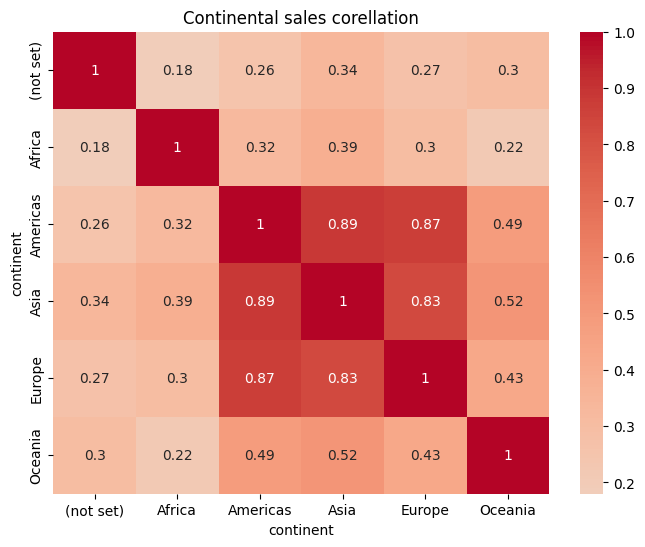

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix_continent, annot=True, cmap="coolwarm", center=0)
plt.title("Continental sales corellation")
plt.show()

At this point picture becomes more interesting - our top 3 continents as Americas, Asia and Europe are showing corellating between each other, while in all other cases the correlations are either weak or nonexistent

### 6.3. Traffic sources corellation

In [ ]:
sales_by_traffic_source = transactions.groupby(['date', 'medium'])['item_id'].count().reset_index()

sales_by_traffic_source

,date,medium,item_id
0,2020-11-01,(data deleted),14
1,2020-11-01,(none),72
2,2020-11-01,<Other>,32
3,2020-11-01,cpc,15
4,2020-11-01,organic,97
...,...,...,...
523,2021-01-27,(none),72
524,2021-01-27,<Other>,39
525,2021-01-27,cpc,8
526,2021-01-27,organic,102


In [ ]:
sales_by_traffic_source_chart = px.line(
    sales_by_traffic_source,
    x="date",
    y="item_id",
    color="medium",
    title="Sales by Traffic Source",
    labels={"date": "Date", "item_id": "Number of Sales"}
)
sales_by_traffic_source_chart.show()

As mentioned earlier, we can distinguish two groups that show strong internal correlations among their members, but no cross-group correlation. To validate this observation, let us build a correlation matrix to either confirm or reject this hypothesis

In [ ]:
sales_pivot_traffic_source = sales_by_traffic_source.pivot(
    index="date",
    columns="medium",
    values="item_id"
)
corr_matrix_traffic_source = sales_pivot_traffic_source.corr()

corr_matrix_traffic_source


medium,(data deleted),(none),<Other>,cpc,organic,referral
medium,,,,,,
(data deleted),1.000000,0.616734,0.505027,0.355434,0.570249,0.629813
(none),0.616734,1.000000,0.828780,0.622044,0.879625,0.830060
<Other>,0.505027,0.828780,1.000000,0.650959,0.839783,0.793652
cpc,0.355434,0.622044,0.650959,1.000000,0.693077,0.571769
organic,0.570249,0.879625,0.839783,0.693077,1.000000,0.823692
referral,0.629813,0.830060,0.793652,0.571769,0.823692,1.000000


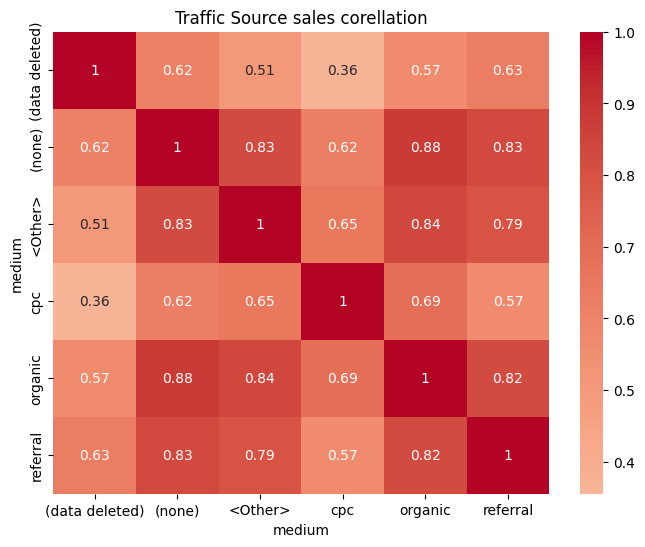

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix_traffic_source, annot=True, cmap="coolwarm", center=0)
plt.title("Traffic Source sales corellation")
plt.show()

From the correlation matrix, we can draw the following conclusions:

 - There is a strong correlation between the sources referral, other, organic, and none.
 - Most of the other sources show a weak but still noticeable positive correlation.
 - The exceptions are cpc and sessions where traffic data is removed: despite the visual similarity of their dynamics on the graphs, their correlation with other sources is the weakest and nearly absent (0.36).

### 6.4. Top 5 Categories corellation

In [ ]:
top_categories = category_metrics.head(5)["category"]


sales_by_top_categories = transactions[transactions["category"].isin(top_categories)].groupby(['date', 'category'])['item_id'].count().reset_index()


sales_by_top_categories

,date,category,item_id
0,2020-11-01,Beds,14
1,2020-11-01,Bookcases & shelving units,74
2,2020-11-01,Cabinets & cupboards,20
3,2020-11-01,Chairs,42
4,2020-11-01,Sofas & armchairs,29
...,...,...,...
435,2021-01-27,Beds,29
436,2021-01-27,Bookcases & shelving units,64
437,2021-01-27,Cabinets & cupboards,27
438,2021-01-27,Chairs,47


In [ ]:
sales_by_top_categories_chart = px.line(
    sales_by_top_categories,
    x="date",
    y="item_id",
    color="category",
    title="Sales by Top Categories",
    labels={"date": "Date", "item_id": "Number of Sales"}
)
sales_by_top_categories_chart.show()

On the charrt above, we can see that the correlation between categories is considerably less stable compared to other metrics. Therefore, let us build a correlation matrix to assess the actual level of correlation

In [ ]:
sales_pivot_categories = sales_by_top_categories.pivot(
    index="date",
    columns="category",
    values="item_id"
)
corr_matrix_categories = sales_pivot_categories.corr()

corr_matrix_categories


category,Beds,Bookcases & shelving units,Cabinets & cupboards,Chairs,Sofas & armchairs
category,,,,,
Beds,1.000000,0.745258,0.616328,0.767301,0.758416
Bookcases & shelving units,0.745258,1.000000,0.670093,0.778980,0.825154
Cabinets & cupboards,0.616328,0.670093,1.000000,0.690972,0.686694
Chairs,0.767301,0.778980,0.690972,1.000000,0.817182
Sofas & armchairs,0.758416,0.825154,0.686694,0.817182,1.000000


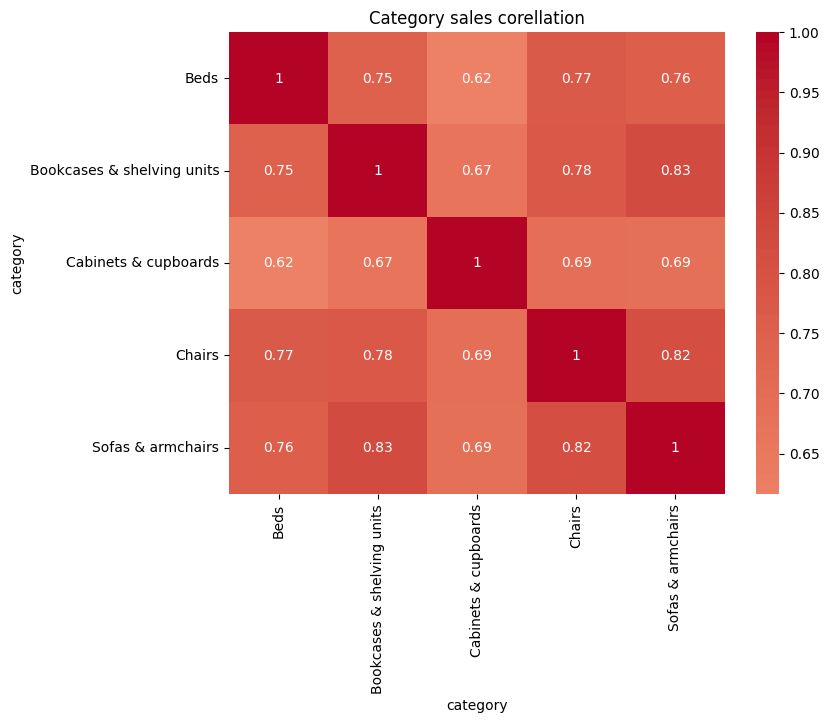

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix_categories, annot=True, cmap="coolwarm", center=0)
plt.title("Category sales corellation")
plt.show()

The correlation matrix shows that, despite lower overall stability, correlations between categories are moderate to strong. In particular, there is a strong correlation between sofas and chairs, as well as between sofas and bookshelves

## 7. Statistical Intergroup differences analysis

### 7.1. Authorized And Unauthorized Users Daily Sales

In [ ]:
transactions['user_type'] = transactions['account_id'].apply(lambda x: 'authorized' if pd.notna(x) else 'unauthorized')


user_type_daily_transactions = transactions.pivot_table(index='date', columns='user_type', values='item_id', aggfunc='count').reset_index()
user_type_daily_transactions

/tmp/ipython-input-1094889197.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



user_type,date,authorized,unauthorized
0,2020-11-01,22,259
1,2020-11-02,33,335
2,2020-11-03,43,518
3,2020-11-04,24,346
4,2020-11-05,27,361
...,...,...,...
83,2021-01-23,27,286
84,2021-01-24,29,267
85,2021-01-25,36,334
86,2021-01-26,32,353


In [ ]:
daily_authorized_purchases = user_type_daily_transactions['authorized']
stats.normaltest(daily_authorized_purchases)

NormaltestResult(statistic=np.float64(8.212356374755585), pvalue=np.float64(0.016470601946921425))

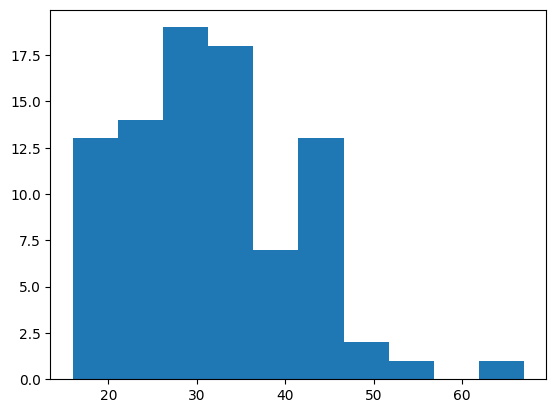

In [ ]:
plt.hist(daily_authorized_purchases)
plt.show()

In [ ]:
daily_unauthorized_purchases = user_type_daily_transactions['unauthorized']
stats.shapiro(daily_authorized_purchases)

ShapiroResult(statistic=np.float64(0.9575441485164817), pvalue=np.float64(0.005719393750019619))

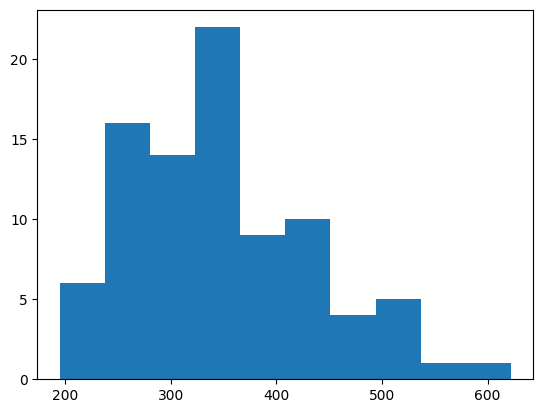

In [ ]:
plt.hist(daily_unauthorized_purchases)
plt.show()

In both cases, the histogram and the statistical tests confirm that the distribution is not normal. This implies that non-parametric methods should be used for further analysis to ensure reliable results

In [ ]:
stats.mannwhitneyu(daily_authorized_purchases, daily_unauthorized_purchases)

MannwhitneyuResult(statistic=np.float64(0.0), pvalue=np.float64(2.1786719630443014e-30))

The analysis reveals a statistically significant difference between authorized and unauthorized users, with authorized users demonstrating a higher purchase rate. This suggests that encouraging more users to register and engage as authorized customers could drive additional sales and overall revenue growth

### 7.2. Traffic Sources Daily Sessions

In [ ]:
traffic_source_daily_traffic = sessions.pivot_table(index='date', columns='medium', values='ga_session_id', aggfunc='count').reset_index()
traffic_source_daily_traffic

medium,date,(data deleted),(none),<Other>,cpc,organic,referral
0,2020-11-01,131,608,359,107,901,470
1,2020-11-02,268,810,511,168,1176,666
2,2020-11-03,336,1216,722,231,1775,893
3,2020-11-04,317,935,632,168,1371,761
4,2020-11-05,349,845,469,150,1232,698
...,...,...,...,...,...,...,...
87,2021-01-27,347,984,610,174,1519,801
88,2021-01-28,270,997,584,170,1325,766
89,2021-01-29,229,878,518,153,1289,633
90,2021-01-30,169,685,409,128,957,497


In [ ]:
daily_organic_sessions = traffic_source_daily_traffic['organic']
stats.normaltest(daily_organic_sessions)

NormaltestResult(statistic=np.float64(9.957778248733588), pvalue=np.float64(0.006881703029113657))

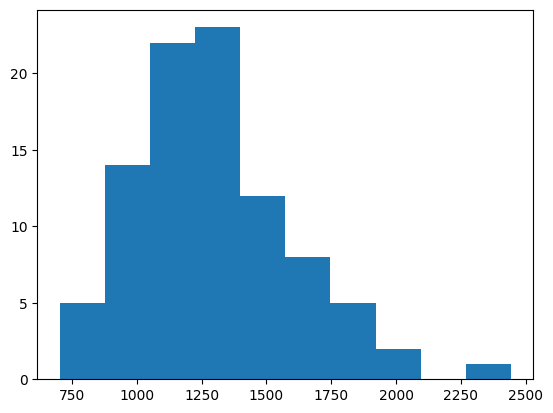

In [ ]:
plt.hist(daily_organic_sessions)
plt.show()

In [ ]:
daily_cpc_sessions = traffic_source_daily_traffic['cpc']
stats.normaltest(daily_cpc_sessions)

NormaltestResult(statistic=np.float64(10.628323426933179), pvalue=np.float64(0.004921402572137335))

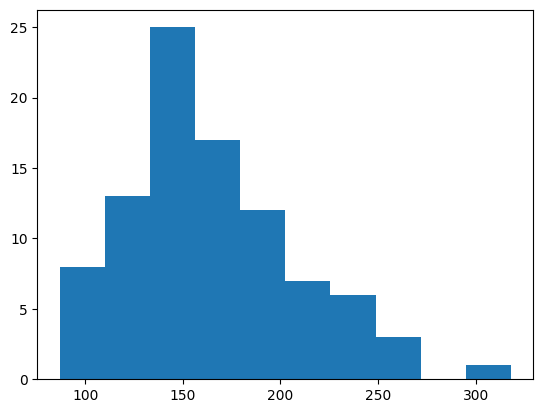

In [ ]:
plt.hist(daily_cpc_sessions)
plt.show()

In [ ]:
daily_referral_sessions = traffic_source_daily_traffic['referral']
stats.normaltest(daily_referral_sessions)

NormaltestResult(statistic=np.float64(6.278706831481535), pvalue=np.float64(0.04331079292738091))

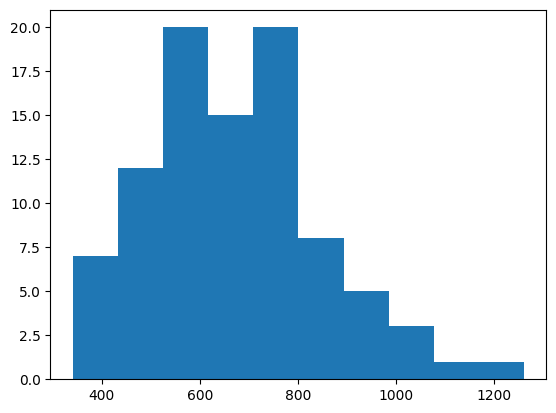

In [ ]:
plt.hist(daily_referral_sessions)
plt.show()

In [ ]:
daily_datadeleted_sessions = traffic_source_daily_traffic['(data deleted)']
stats.normaltest(daily_datadeleted_sessions)

NormaltestResult(statistic=np.float64(6.686321676027277), pvalue=np.float64(0.03532512407567399))

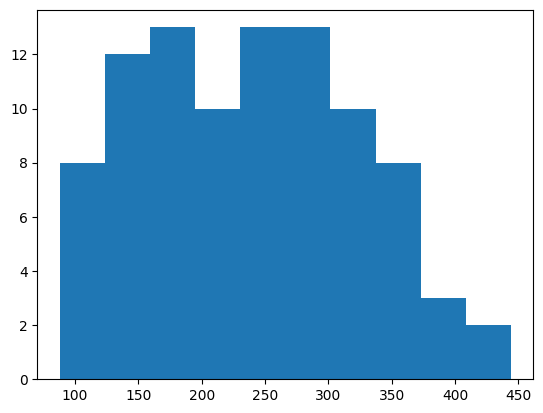

In [ ]:
plt.hist(daily_datadeleted_sessions)
plt.show()

In [ ]:
daily_datadeleted_sessions = traffic_source_daily_traffic['(data deleted)']
stats.normaltest(daily_datadeleted_sessions)

NormaltestResult(statistic=np.float64(6.686321676027277), pvalue=np.float64(0.03532512407567399))

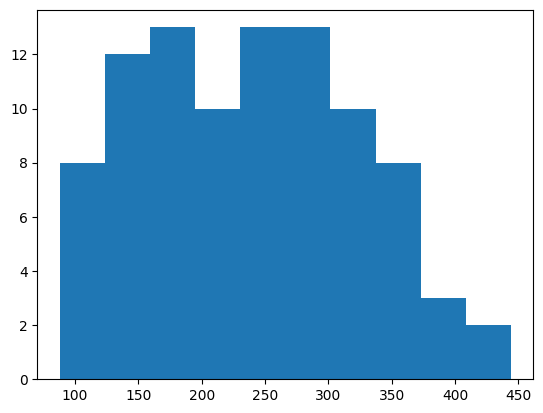

In [ ]:
plt.hist(daily_datadeleted_sessions)
plt.show()

In [ ]:
daily_none_sessions = traffic_source_daily_traffic['(none)']
stats.normaltest(daily_datadeleted_sessions)

NormaltestResult(statistic=np.float64(6.686321676027277), pvalue=np.float64(0.03532512407567399))

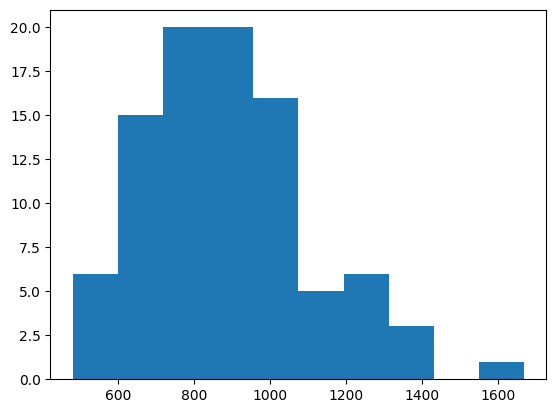

In [ ]:
plt.hist(daily_none_sessions)
plt.show()

In [ ]:
daily_other_sessions = traffic_source_daily_traffic['<Other>']
stats.normaltest(daily_other_sessions)

NormaltestResult(statistic=np.float64(17.167997706439465), pvalue=np.float64(0.00018707539262932874))

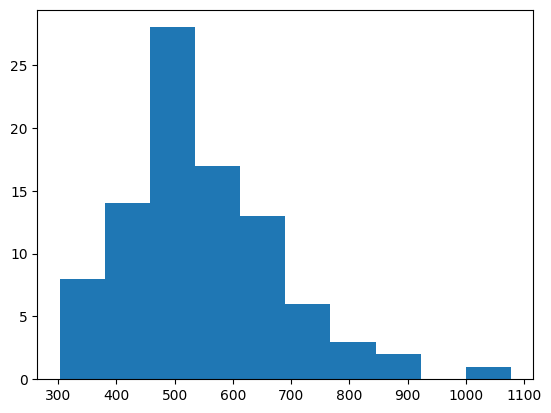

In [ ]:
plt.hist(daily_other_sessions)
plt.show()

Although the distributions appear close to normal visually, statistical tests reject normality. This suggests that parametric methods may not be fully reliable, and non-parametric approaches or data transformations should be considered to ensure robust results

In [ ]:
stats.kruskal(daily_organic_sessions, daily_cpc_sessions, daily_referral_sessions, daily_datadeleted_sessions, daily_none_sessions, daily_other_sessions)

KruskalResult(statistic=np.float64(473.3351661328476), pvalue=np.float64(4.5383316811405925e-100))

As the Kruskal-Wallis test shows, there is a statistically significant difference between traffic sources, indicating that customers from different channels may require differentiated approaches

### 7.3 Daily Organic Sessions in Europe and Americas

In [ ]:
daily_total_sessions = (sessions[sessions['continent'].isin(['Europe', 'Americas'])].pivot_table(index='date', columns='continent', values='ga_session_id', aggfunc='count').reset_index())

daily_organic_sessions = (sessions[(sessions['continent'].isin(['Europe', 'Americas'])) & (sessions['medium'] == 'organic')].pivot_table(index='date', columns='continent', values='ga_session_id', aggfunc='count').reset_index())

daily_organic_shares = daily_total_sessions.merge(daily_organic_sessions, on='date', suffixes=('_total', '_organic'))


for continent in ['Europe', 'Americas']:
    daily_organic_shares[f'{continent}_share'] = daily_organic_shares[f'{continent}_organic'] / daily_organic_shares[f'{continent}_total'] * 100

daily_organic_shares

continent,date,Americas_total,Europe_total,Americas_organic,Europe_organic,Europe_share,Americas_share
0,2020-11-01,1474,463,526,162,34.989201,35.685210
1,2020-11-02,1968,659,617,220,33.383915,31.351626
2,2020-11-03,2814,913,926,336,36.801752,32.906894
3,2020-11-04,2255,834,763,262,31.414868,33.835920
4,2020-11-05,2015,724,675,241,33.287293,33.498759
...,...,...,...,...,...,...,...
87,2021-01-27,2487,818,855,272,33.251834,34.378770
88,2021-01-28,2338,720,752,238,33.055556,32.164243
89,2021-01-29,2027,682,709,247,36.217009,34.977800
90,2021-01-30,1614,510,556,178,34.901961,34.448575


In [ ]:
daily_americas_organic_sessions = daily_organic_shares['Americas_share']
stats.normaltest(daily_americas_organic_sessions)

NormaltestResult(statistic=np.float64(0.5022822659151283), pvalue=np.float64(0.7779125747087675))

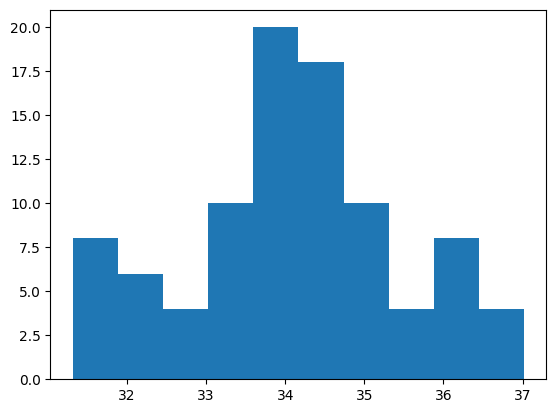

In [ ]:
plt.hist(daily_americas_organic_sessions)
plt.show()

In [ ]:
daily_europe_organic_sessions = daily_organic_shares['Americas_share']
stats.normaltest(daily_europe_organic_sessions)

NormaltestResult(statistic=np.float64(0.5022822659151283), pvalue=np.float64(0.7779125747087675))

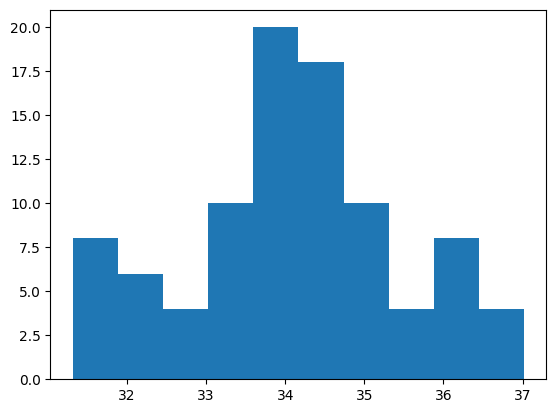

In [ ]:
plt.hist(daily_europe_organic_sessions)
plt.show()

Although formal statistical tests do not reject the null hypothesis of normality, the histogram reveals wave-like fluctuations. This pattern may indicate residual seasonality, the presence of subgroups (e.g. diffferent categories of items), or sampling variability where random noise creates visible waves.

In [ ]:
stat, p_value = sm.stats.proportions_ztest( [daily_americas_organic_sessions.sum(), daily_europe_organic_sessions.sum()], [daily_organic_shares['Americas_total'].sum(), daily_organic_shares['Europe_total'].sum()])
p_value

np.float64(0.0)

Despite the similarity in distributions, the statistical test indicates a significant difference in the share of organic customers between the Americas and Europe. This finding suggests that tailored strategies or differentiated approaches may be required for these two regions

## 8. Dashboard

I have also built a Tableau dashboard showcasing sales dynamics and overall sales performance. The dashboard provides an interactive view with high-level summaries and trend analysis, and is accessible via a dedicated link - https://public.tableau.com/app/profile/oleh.vasyliev/viz/FurnitureStore_17584883824060/SalesOverview?publish=yes

## 9. Conclusions

### 9.1. Overview

The dataset encompasses 349,545 unique sessions, with 33,538 resulting in transactions. The majority of sales are driven by desktop users (58.7%), followed by mobile (39.1%), with tablets contributing minimally (2.2%). Geographically, the Americas lead in revenue generation, closely followed by Asia and Europe. Sofas, chairs, and beds are the top revenue contributors, with sofas also having the highest average revenue per item.



### 9.2. Insights

- There is no customer retention at all - each user buyes only once and only one item
- Differences in the behavior of buyers from different regions have been noted and confirmed by statistical tests, which requires a differentiated approach to marketing strategies.
- The United States, India, and Canada are the top-performing countries. Tailoring marketing strategies to these regions could yield significant returns
- High-value categories like "Sofas & armchairs" and "Beds" not only generate substantial revenue but also have higher average order values, indicating opportunities for upselling or focused promotions.

### 9.3. Recommendations

- Expand sales reporting to cover a longer timeline
- Develop a customers retention stragedy
- Introduce cart functionality to enable multiple-item purchases
- Provide new traffic source to increase visibiity
- Encourage authorized users to increase purchase frequency and conversion
- Apply differentiated approaches for distinct customer segments
- Optimize data collection and storage processes

## Thanks for your time!